# Development of Numeric Simulation Predicting Material Behavior

Kuanlin Chen, PhD student of the schulman lab<br>
Advisor: Rebecca Schulman, PhD<br>
Johns Hopkins University

**Keywords: Numeric Simulation**

***
#### Summary:

Using data from the swelling characterization of bilayer DNA-co-polymerized hydrogel, we developed numeric simulation that accurately predicts the geometric outputs of the strip automata. 

We characterized the radius of curvature of bilayer gels upon different actuation combination along with the change in contour length. The values are stored in callable RoC tables and contour length tables that are used to retrieve values during geometric output simulation. 

We assumed the stack of bilayer gels do not interfere with each other upon actuation given the orthogonal operating actuators and also ignoring the minimal shear stress during swelling. 

We start with taking a 1d array `segment_lengths` and a 2d array `identities` as inputs, and generate an strip automata object. The `segment_lengths` array encodes the information of the **length** in each segment. The `identities` encodes the information of the **actuator pattern** in each segment. We then simulate the 16 possible states given our 4 switchable actuator system ($2^{4}=16$), thus every automata object contains 16 output images in the end. Upon simulation, we first retrieve the values for radius of curvature and delta contour length with the callable RoC tables and contour length tables, and obtain a 1d array `rocs` for the radius of curvature of each segments and a 1d array `ctls` for the delta contour length of each segments. We next use these values and integrate over the length and angle to derive the final shape. Starting at (x, y) = (0, 0) and $\theta = 0$, we use `delta = 20um` as a mesh size and an iterator object to generate the next (x, y) point. Points are generated with the following rules:

$\Delta \theta = \frac{delta}{radius-of-curvature}$

$\theta = \theta + \Delta \theta$

$\Delta x = delta \cdot sin(\theta)$

$\Delta y = delta \cdot cos(\theta)$

$x = \theta + \Delta x$

$y = \theta + \Delta y$

The iterator generates new point until reaching segment length limit $(segment\_length \cdot (1 + \Delta contour\_length))$ and goes on generating new points for next segments until all segments are generated. We next compile a 28 x 28 pixel images using the shape of the x, y points and apply Gaussian filters to the final generated images representing the actuator geometric outputs, so the images emulate the shape of MNIST digits prior to training and classification.  

In [3]:
# Package Importing
import csv, math, os, time, copy, matplotlib, datetime, keras

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import io as spio
from scipy.ndimage import gaussian_filter
from scipy.stats import bernoulli

from math import log10, floor

from skimage import transform, exposure

print(keras.__version__) # 2.4.3
print(tf.__version__) # 2.2.0

2.4.3
2.2.0


## Material Behavior Characterization

We characterize the radius of curvature and change in contour length of the bilayer gels upon different actuator combination and created the following table.

**RoC Matrix**

*Definition*

- RoC bending downward is positive, bending upward (ex. shape U) negative. 
- **nc**: for no curvature = 1e5, **-**: for no value, but still put in 1e8 to avoid confusing the table.
- Lacking most data for pos_pos matrix, for systems sharing similar swelling behavior (sys 1, 2, 4) when both swollen, assume RoC = nc; for system 3, that swells a lot, assume slight bending caused and value = 3500um.

|top neg, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|nc  |5e3|5e3|5e3|5e3|
|1|-5e3|nc |nc |nc |nc |
|2|-5e3|nc |nc |nc |nc |
|3|-5e3|nc |nc |nc |nc |
|4|-5e3|nc |nc |nc |nc |

|top pos, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|-|-|-|-|
|1|-|nc|nc|3500|nc|
|2|-|nc|nc|3500|nc|
|3|-|-3500|-3500|nc|-3500|
|4|-|nc|nc|3500|nc|

|top pos, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|730|740|770|630|
|1|-|-  |820|570|500|
|2|-|770|-  |667|667|
|3|-|725|650|-  |670|
|4|-|690|695|830|-  |

|top neg, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-   |-   |-   |-   |-   |
|1|-730|-   |-770|-725|-690|
|2|-740|-820|-   |-650|-695|
|3|-770|-570|-667|-   |-830|
|4|-630|-500|-667|-670|-   |

**Contour Matrix**

- for pos_pos, use the value from monolayer for diagonals, and slightly uptune/downtune for paired systems.
- for pos_neg, downtune .2 for connection with no-DNAs.

|top neg, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|1|1|1|1|1
|1|1|1|1|1|1
|2|1|1|1|1|1
|3|1|1|1|1|1
|4|1|1|1|1|1

|top pos, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|-|-|-|-|
|1|-|1.45|1.4|1.55|1.42|
|2|-|1.4|1.4|1.5|1.4|
|3|-|1.55|1.5|1.75|1.55|
|4|-|1.42|1.4|1.55|1.45|

|top pos, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|1.22|1.14|1.3|1.33|
|1|-|   -|1.16|1.32|1.25|
|2|-|1.24|-   |1.59|1.50|
|3|-|1.18|1.20|-   |1.35|
|4|-|1.19|1.23|1.32|-   |

|top neg, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-          |   -|   -|   -|   -|
|1|1.22| -  |1.24|1.18|1.19|
|2|1.14|1.16|-   |1.20|1.23|
|3|1.30|1.32|1.59|-   |1.32|
|4|1.33|1.25|1.50|1.35|-   |

In [4]:
# Set up the RoC matrix
actuator_types = 4; nc = 1e5; na = 1e8
neg_neg_rocs = [[nc, 5e3, 5e3, 5e3, 5e3],[-5e3, nc, nc, nc, nc],[-5e3, nc, nc, nc, nc],[-5e3, nc, nc, nc, nc],[-5e3, nc, nc, nc, nc]]
pos_pos_rocs = [[na, na, na, na, na],[na, nc, nc, 3500, nc],[na, nc, nc, 3500, nc],[na, -3500, -3500, nc, -3500],[na, nc, nc, 3500, nc]]
pos_neg_rocs = [[na, 730, 740, 770, 630],[na, na, 820, 570, 500],[na, 770, na, 667, 667],[na, 725, 650, nc, 670],[na, 690, 695, 830, na]]
neg_pos_rocs = [[na, na, na, na, na],[-730, na, -770, -725, -690],[-740, -820, na, -650, -695],[-770, -570, -667, na, -830],[-630, -500, -667, -670, na]]
four_t_rocs = [[neg_neg_rocs, neg_pos_rocs],[pos_neg_rocs, pos_pos_rocs]]

# Set up the ContourLength matrix
na = 1
neg_neg_ctls = [[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]]
pos_pos_ctls = [[na, na, na, na, na],[na, 1.45, 1.4, 1.55, 1.42],[na, 1.4, 1.4, 1.5, 1.4],[na, 1.55, 1.5, 1.75, 1.55],[na, 1.42, 1.4, 1.55, 1.45]]
pos_neg_ctls = [[na, 1.22, 1.14, 1.3, 1.33],[na, na, 1.16, 1.32, 1.25],[na, 1.24, na, 1.59, 1.50],[na, 1.18, 1.20, nc, 1.35],[na, 1.19, 1.23, 1.32, na]]
neg_pos_ctls = [[na, na, na, na, na],[1.22, na, 1.24, 1.18, 1.19],[1.14, 1.16, na, 1.20, 1.23],[1.3, 1.32, 1.59, na, 1.32],[1.33, 1.25, 1.50, 1.35, na]]
four_t_ctls = [[neg_neg_ctls, neg_pos_ctls],[pos_neg_ctls, pos_pos_ctls]]

In [5]:
class SegmentedCurve:
    """
    Object that defines a curve. A curve is defined with following properties:

        1. segment lengths *list*
            - list of numbers specifying the length of each segments making up the curve.
            - unit: um
        2. rocs *list*
            - list of numbers specifying the radius of curvature of each segment.
            - set it to a high number such as 1e5 for flat line.
        3. ctls *list*
            - list of the contour length change for each segments.

    Functions:

        1. set_points
            - generate the curve as a list of points.
        2. rotate
            - rotate the curve.
        3. translate
            - translate the curve.
        4. generate_image
            - generate the image of the curve from the points.
        5. plot
            - plot the curve.
    """

    def __init__(self, segment_lengths, rocs = [], ctls = []):
        """
        By default this curve starts at (0, 0) and tangent angle 0. Deafault ROC is 999999.
        """
        
        self.segment_lengths = segment_lengths
        if not rocs:
            self.rocs = np.ones_like(segment_lengths) * 999999
        else:
            self.rocs = rocs
        if not ctls:
            self.segment_lengths = np.array(segment_lengths) 
        else:
            self.segment_lengths = np.array(segment_lengths) * ctls
         
        self.initial_point = [0, 0]
        self.initial_tangent_angle = 0
        self.set_points()
        
    def set_points(self):
        """
        Start generating the rest of the segment points from the origin and based one the segment length and ROC.
        """
        s_iter = SegmentedCurveIterator(self)
        self.x_points = []; self.y_points = []
        self.tangent_angles = []
        while True:
            try:
                element = next(s_iter)
                self.x_points.append(element[0])
                self.y_points.append(element[1])
                self.tangent_angles.append(s_iter.tangent_angle)
            except StopIteration:
                break    
    
    def rotate(self, angle):
        """
        Rotate the curve by adding an angle, and regrowing the rest of the curve.
        """
        self.initial_tangent_angle += angle
        self.set_points()
        
    def translate(self, coords):
        """
        Translate the curve by shifting its origin, and regrowing the rest of the curve.
        """
        self.initial_point += coords
        self.set_points()
        
    def generate_image(self, width = 28, height = 28, padding = 0, filter = None, filter_sigma = 1):
        """
        Generates the image of the curve.
        **Parameters**
            width *int*
                the width of the image in pixel.
            height *int*
                the height of the image in pixel.
                As the trained images are 28 x 28 pixels images, we return an image of the same size.
            padding *int*
                - provide additional space if needed.
                - not sure working or not...
            filter *string*
                Can choose None or "Gaussian", used to blur the image so it resembles the digits more.
            filter_sigma *int or float*
                Sigma for the Gaussian filter.
        """
        contour_length = np.sum(self.segment_lengths)
        half_dimension = 1.5 * contour_length / (2 * math.sqrt(2))
        #print("Old half dimension was  "+ str(half_dimension))
        x_span = np.amax(self.x_points) - np.amin(self.x_points)
        y_span = np.amax(self.y_points) - np.amin(self.y_points)
        half_dimension = max([x_span, y_span])
        #print("Half dimension is " + str(half_dimension))
        x_center = np.median(self.x_points)
        y_center = np.median(self.y_points)
        new_x = np.array(self.x_points) - x_center
        new_y = np.array(self.y_points) - y_center
        new_x = new_x * (width / 2 + padding) // half_dimension
        new_y = new_y * (height / 2 + padding) // half_dimension
        image_pixels = np.zeros(shape = (height + 2 * padding, width + 2 * padding))
        for i in range(len(new_x)):
            image_pixels[math.floor(new_y[i]) + math.floor(height / 2) + padding][math.floor(new_x[i]) + math.floor(width / 2) + padding] += 1
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        image_pixels = image_pixels / np.amax(image_pixels, axis=(0, 1))
        image_pixels = transform.resize(image_pixels, (width + padding, height + padding))
        if filter is "Gaussian":
            image_pixels = gaussian_filter(image_pixels, sigma = filter_sigma)
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        return image_pixels
    
    def generate_image_v2(self, width = 28, height = 28, padding = 0, filter = "Gaussian",\
                          filter_sigma = .8, half_dimension = 5000):
        """
        Generates the image of the curve.
        **Parameters**
            width *int*
                the width of the image in pixel.
            height *int*
                the height of the image in pixel.
                As the trained images are 28 x 28 pixels images, we return an image of the same size.
            padding *int*
                - provide additional space if needed.
                - not sure working or not...
            filter *string*
                Can choose None or "Gaussian", used to blur the image so it resembles the digits more.
            filter_sigma *int or float*
                Sigma for the Gaussian filter.
        """
        
        #print("Half dimension is " + str(half_dimension))
        x_center = np.median(self.x_points)
        y_center = np.median(self.y_points)
        new_x = np.array(self.x_points) - x_center
        new_y = np.array(self.y_points) - y_center
        new_x = new_x * (width / 2 + padding) // half_dimension
        new_y = new_y * (height / 2 + padding) // half_dimension
        image_pixels = np.zeros(shape = (height + 2 * padding, width + 2 * padding))
        for i in range(len(new_x)):
            image_pixels[math.floor(new_y[i]) + math.floor(height / 2) + padding][math.floor(new_x[i]) + math.floor(width / 2) + padding] += 1
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        image_pixels = image_pixels / np.amax(image_pixels, axis=(0, 1))
        image_pixels = transform.resize(image_pixels, (width + padding, height + padding))
        if filter is "Gaussian":
            image_pixels = gaussian_filter(image_pixels, sigma = filter_sigma)
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        return image_pixels
        
    def plot(self):
        """
        Plot and show the curve.
        """
        fig, ax = plt.subplots(1, 1, figsize = (5, 5))
        ax.plot(self.x_points, self.y_points, linewidth = 15)
        plt.show()

class SegmentedCurveIterator:
    """
    This class is mainly used as the generator for the SegmentedCurve class.
    """
    def __init__(self, segmented_curve):
        self.rocs = segmented_curve.rocs
        self.segment_starts = np.cumsum(segmented_curve.segment_lengths) - segmented_curve.segment_lengths
        self.curve_end = np.sum(segmented_curve.segment_lengths)
        self.segment_starts = np.append(self.segment_starts,[self.curve_end])
        self.last_point = segmented_curve.initial_point
        self.tangent_angle = segmented_curve.initial_tangent_angle
        self.current_length = 0; self.current_segment = 0
        # delta can be considered as the MESH SIZE for segments.
        self.delta = 20
        
    def __next__(self):
        self.current_length += self.delta
        if self.current_length > self.curve_end:
            raise StopIteration()
        if self.current_length > self.segment_starts[self.current_segment + 1]:
            self.current_segment += 1
        angle_change = self.delta / self.rocs[self.current_segment]
        self.tangent_angle += angle_change
        pos_change = [self.delta*math.sin(self.tangent_angle), \
                      self.delta*math.cos(self.tangent_angle)]
        self.last_point = np.add(self.last_point,pos_change)
        return self.last_point

In [15]:
def get_curvature(rocs, states, top_type, bottom_type):
    """
    Table reading function for retrieving the curvature and contour length change.
    """
    return rocs[int(states[int(top_type)])][int(states[int(bottom_type)])][int(top_type)][int(bottom_type)]

In [16]:
class ActuatorStrip:
    """
    Object that defines a bilayer hydrogel actuator. An actuator strip is defined with following properties:

        1. lengths *list*
            - list of numbers specifying the length of each segments making up the curve.
            - unit: um
        2. identities *list*
            - the actuator system that each segment is patterned with.
        3. rocs *list*
            - radius of curvature table for bilayer 
            - set it to a high number such as 1e5 for flat line.
        4. ctls *list(
            - contour length table for bilayer
    """
    
    def __init__(self, lengths, identities, rocs, ctls):
        self.segment_lengths = lengths
        self.identities = identities
        self.rocs = rocs
        self.ctls = ctls
        self.actuator_types = len(rocs[0][0]) - 1
        self.self_intersecting = []      
        self.output_info = {}
        self.selected = {}

    def generate_curves(self):
        """
        Generates the points for all possible strips formed.
        """
        self.curves = []
        for i in range(pow(2, self.actuator_types)):
            # i is an integer -- the qth bit of i in binary encodes whether the qth actuator type is on. 
            curvatures = []; ctlengths = []; states = [0]
            for k in range(self.actuator_types):
                # << bitwise shift operators
                if i & (1 << k):
                    states.append(1)
                else:
                    states.append(0)
#             print(states) # see how each image states is made
            for j in range(len(self.segment_lengths)):
                curvatures.append(get_curvature(self.rocs, states, self.identities[0][j], self.identities[1][j]))
                ctlengths.append(get_curvature(self.ctls, states, self.identities[0][j], self.identities[1][j]))
            s = SegmentedCurve(self.segment_lengths, curvatures, ctlengths)
            self.curves.append(s)
  
    def determine_self_intersection(self):
        """
        NEED A FASTER self intersecting check, currently not in use.
        """
        state_count = pow(2, self.actuator_types)
        for j in range(state_count):
            #print("Looking at self intersection " + str(j))
            #self.self_intersecting.append(self.curves[j].is_self_intersecting())
            self.self_intersecting.append(0)
            #print("Self intersecting is now " + str(self.self_intersecting))
            
    def plot_input_design(self, save = False, cm = plt.cm.get_cmap('tab20')):
        fig , ax = plt.subplots(1, figsize = (5, 5))
        fig_width = int(np.sum(self.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(self.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

        for i in range(len(self.segment_lengths)):
            ax.annotate("%dum"%(self.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(self.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(self.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")
#         plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_input.png", dpi = 600)
        plt.show()
        
    def analysis(self, rotation = 20):
        
        self.generate_curves()
        bestImgs = np.zeros(shape = (16, 28, 28)); bctr = 0; HAS9 = 0; HAS6 = 0
        state_name = ["ALL OFF", "S1 ON", "S2 ON", "S1 & S2",
                      "S3 ON", "S1 & S3", "S2 & S3", "S1 & S2 & S3",
                      "S4 ON", "S1 & S4", "S2 & S4", "S1 & S2 & S4",
                      "S3 & S4", "S1 & S3 & S4", "S2 & S3 & S4", "ALL ON"]
        rotations = []
        
        for curve in self.curves:
            possibility = np.zeros(shape = (rotation, 28, 28)); ctr = 0
            
            for _ in range(rotation):
                curve.rotate(2*math.pi / rotation)
                img = curve.generate_image(filter = 'Gaussian')
                possibility[ctr]=img;ctr+=1
            score = cnn_digit_model.predict(possibility.reshape(possibility.shape[0], 28, 28, 1))
            info = [(i, np.argmax(score[i]), score[i][np.argmax(score[i])]) for i in range(len(score)) if np.argmax(score[i]) < 10]

            if info:
                best = np.argmax([info[i][2] for i in range(len(info))])
                if info[best][1] == 9:
                    if not HAS9:
                        HAS9 = True
                        bestImgs[bctr] = possibility[info[best][0]]
                    elif not HAS6:
                        try: 
                            best = [info[i][1] for i in range(len(info))].index(6)
                            bestImgs[bctr] = possibility[info[best][0]]
                        except:
                            bestImgs[bctr] = possibility[info[best][0]]
                    else:
                        bestImgs[bctr] = possibility[info[best][0]]
                elif info[best][1] == 6:
                    if not HAS6:
                        HAS6 = True
                        bestImgs[bctr] = possibility[info[best][0]]
                    elif not HAS9:
                        try: 
                            best = [info[i][1] for i in range(len(info))].index(9)
                            bestImgs[bctr] = possibility[info[best][0]]
                        except:
                            bestImgs[bctr] = possibility[info[best][0]]
                    else:
                        bestImgs[bctr] = possibility[info[best][0]]
                else:
                    bestImgs[bctr] = possibility[info[best][0]]
            else:
                bestImgs[bctr] = possibility[-2]
            rotations.append((best+1)*2*math.pi / rotation)
            bctr += 1
        score = cnn_digit_model.predict(bestImgs.reshape(16, 28, 28, 1))
        info = [(np.argmax(score[i]), score[i][np.argmax(score[i])]) for i in range(len(score))]
        
        
        self.output_info = {i:{"img":bestImgs[i], "dig":info[i][0], "score":info[i][1], "state":state_name[i],\
                               "rotations":rotations[i]} for i in range(16)}

        contest = [[] for i in range(11)];
        [contest[self.output_info[i]["dig"]].append((self.output_info[i]["score"], i)) for i in self.output_info]
        for i in range(11):
            if contest[i] and i!=10:
                self.selected[i] = {"img":self.output_info[sorted(contest[i])[-1][1]]["img"],\
                                    "score":sorted(contest[i])[-1][0],\
                                    "num":sorted(contest[i])[-1][1],\
                                    "state":self.output_info[sorted(contest[i])[-1][1]]["state"]}
                
    def generate_unscaled_imgs(self, filter_sigma = .8, half_dimension = 5000):
        
        self.generate_curves(); self.unscaled_imgs = np.zeros(shape = (16, 28, 28))

        for i in range(16):
            curve = self.curves[i]; curve.rotate(self.output_info[i]["rotations"])
            img = curve.generate_image_v2(filter_sigma = filter_sigma, half_dimension = half_dimension)
            self.unscaled_imgs[i] = img
                
    def plot_output_map(self, score = True, save = False):
        
        state_count = pow(2, self.actuator_types)
        if state_count != 16:
            raise WrongDesignType()
            
        title_name = ["ALL OFF", "S1 ON", "S2 ON", "S1 & S2",
              "S3 ON", "S1 & S3", "S2 & S3", "S1 & S2 & S3",
              "S4 ON", "S1 & S4", "S2 & S4", "S1 & S2 & S4",
              "S3 & S4", "S1 & S3 & S4", "S2 & S3 & S4", "ALL ON"]
        fig = plt.figure(figsize = (6,6)); ctr = 0
        
        self.generate_curves()
        for i in range(state_count):
            plt.subplot(4, 4, ctr+1)
            curve = self.curves[i]; img = curve.generate_image(filter = 'Gaussian')
            plt.imshow(img)
            plt.title(title_name[i], fontsize = 10, family = "serif", weight = "bold", y = .95)
            if score:
                scores = cnn_digit_model.predict(img.reshape(1,28,28,1))[0]
                plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(np.argmax(scores), np.max(scores)), fontsize = 12, family = "serif", weight = "bold", color = "white")
            plt.axis(False); ctr += 1
        fig.suptitle("Output Map", fontsize = 12, family = "serif", weight = "bold", y = .95)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_output.png", dpi = 600)
        plt.show()
        
    def plot_advanced_output_map(self, rotation = 20, save = False):
        """
        - Enables rotation and mirroring to search larger space
        - Enables simultaneous presense of 6 and 9
        """

        if not self.output_info or rotation != 20:
            self.analysis(rotation = rotation)
        
        fig = plt.figure(figsize = (6,6)); ctr = 0
        
        for i in range(pow(2, self.actuator_types)):
            plt.subplot(4, 4, ctr+1)
            img = self.output_info[ctr]["img"]
            plt.imshow(img)
            plt.title(self.output_info[ctr]["state"], fontsize = 10, family = "serif", weight = "bold", y = .95)
            plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(self.output_info[ctr]["dig"], self.output_info[ctr]["score"]), fontsize = 12, family = "serif", weight = "bold", color = "white")
            plt.axis(False); ctr += 1
        fig.suptitle("Output Map", fontsize = 12, family = "serif", weight = "bold", y = .95)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_advancedoutput.png", dpi = 600)
        plt.show()
        
    def plot_selected_output_map(self, rotation = 20, save = False):

        if not self.selected or rotation != 20:
            self.analysis(rotation = rotation)
        
        fig = plt.figure(figsize = (10, 4))
        
        for i in range(10):
            plt.subplot(2, 5, i+1)
            if i in self.selected.keys():
                img = self.selected[i]['img']
                plt.imshow(img)
                plt.text(img.shape[1]*.05, img.shape[1]*.9, "Score: {:.3f}".format(self.selected[i]['score']), fontsize = 12, family = "serif", weight = "bold", color = "white")
                plt.title("{} ({})".format(i, self.selected[i]['state']), fontsize = 10, family = "serif", weight = "bold", y = .98)
            else:
                plt.imshow(np.zeros(shape = (28, 28)))
                plt.title("{} (n.a.)".format(i), fontsize = 10, family = "serif", weight = "bold", y = .98)
            plt.axis(False)
        fig.suptitle("Optimized Output Map", fontsize = 15, family = "serif", weight = "bold", y = .98)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_selectedoutput.png", dpi = 600)
        plt.show()
        
    def plot_input_and_all(self, rotation = 20, save = False):
        
        if not self.selected or rotation != 20:
            self.analysis(rotation = rotation)
            
        fig = plt.figure(figsize=(12,6))
        
        ax = plt.subplot(1,2,1)
        fig_width = int(np.sum(self.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(self.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

        for i in range(len(self.segment_lengths)):
            ax.annotate("%dum"%(self.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(self.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(self.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")
        plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)
             
        ctr = 0; shiftlist = [5,5,5,5,9,9,9,9,13,13,13,13,17,17,17,17]
        for i in range(pow(2, self.actuator_types)):
            plt.subplot(4, 8, ctr + shiftlist[ctr])
            img = self.output_info[ctr]["img"]
            plt.imshow(img)
            plt.title(self.output_info[ctr]["state"], fontsize = 10, family = "serif", weight = "bold", y = .95)
            plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(self.output_info[ctr]["dig"], self.output_info[ctr]["score"]), fontsize = 12, family = "serif", weight = "bold", color = "white")
            plt.axis(False); ctr += 1
            
        fig.suptitle("Design Input and Output Map", fontsize = 15, family = "serif", weight = "bold", y = .95)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_inandoutput.png", dpi = 600)
        plt.show()
        
    def plot_input_and_all_adobe(self, rotation = 20, save = False):
        
        if not self.selected or rotation != 20:
            self.analysis(rotation = rotation)
            
        fig = plt.figure(figsize=(12,6))
        
        ax = plt.subplot(1,2,1)
        fig_width = int(np.sum(self.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
#         colors = ["#808080", "#FFB3AB", "#FFC658", "#1D57A5", "#A86F5F"]
        colors = ["#808080", "#0072BD", "#D95319", "#EDB120", "#7E2F8E"]
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(self.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = colors[self.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = colors[self.identities[1][i]]))

        plt.axis(False)
             
        ctr = 0; shiftlist = [5,5,5,5,9,9,9,9,13,13,13,13,17,17,17,17]
        for i in range(pow(2, self.actuator_types)):
            plt.subplot(4, 8, ctr + shiftlist[ctr])
            img = self.output_info[ctr]["img"]
            plt.imshow(img, cmap = "binary")
#             plt.title(self.output_info[ctr]["state"], fontsize = 10, family = "serif", weight = "bold", y = .95)
#             plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(self.output_info[ctr]["dig"], self.output_info[ctr]["score"]), fontsize = 12, family = "serif", weight = "bold", color = "white")
            plt.axis(False); ctr += 1
            
#         fig.suptitle("Design Input and Output Map", fontsize = 15, family = "serif", weight = "bold", y = .95)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_inandoutput.svg", dpi = 80)
        plt.show()
        
    def plot_input_and_selected(self, rotation = 20, save = False):
        
        if not self.selected or rotation != 20:
            self.analysis(rotation = rotation)
            
        fig = plt.figure(figsize=(16,4))
        
        ax = plt.subplot(1,4,1)
        fig_width = int(np.sum(self.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(self.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 11, color = "white", family = "serif", weight = "bold")

        for i in range(len(self.segment_lengths)):
            ax.annotate("%dum"%(self.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(self.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(self.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 11, color = "white", family = "serif", weight = "bold")
        plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)
        plt.subplots_adjust(wspace = 0.01, hspace = .2)
        
        shiftlist = list(range(3,8))+list(range(10,15))
        for i in range(10):
            plt.subplot(2, 7, shiftlist[i])
            if i in self.selected.keys():
                img = self.selected[i]['img']
                plt.imshow(img)
                plt.text(img.shape[1]*.05, img.shape[1]*.9, "Score: {:.3f}".format(self.selected[i]['score']), fontsize = 12, family = "serif", weight = "bold", color = "white")
                plt.title("{} ({})".format(i, self.selected[i]['state']), fontsize = 12, family = "serif", weight = "bold", y = .98)
            else:
                plt.imshow(np.zeros(shape = (28, 28)))
                plt.title("{} (n.a.)".format(i), fontsize = 12, family = "serif", weight = "bold", y = .98)
            plt.axis(False)
        fig.suptitle("Design Input and Optimized Output Map", fontsize = 16, family = "serif", weight = "bold", y = 1.05)
        plt.subplots_adjust(wspace = 0.01, hspace = .2)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_selectedoutput.png", dpi = 600)
        plt.show()
        
    def save_imgs(self, rotation = 20, path = os.getcwd()):
        
        if not self.output_info or rotation != 20:
            self.analysis(rotation = rotation)
            
        for i in range(16):
            try:
                objt = self.output_info; foldername = "d{}".format(objt[i]["dig"]); filename = datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_output.png";
                plt.imsave("/".join((path, foldername, filename)), objt[i]["img"], cmap = "gray")
            except:
                continue

#### Plotting a Sample Design

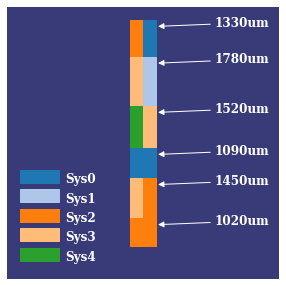

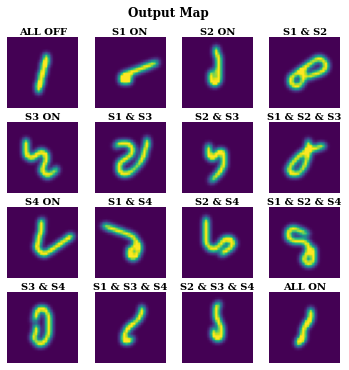

In [21]:
idts = [[2,3,4,0,3,2],[0,1,3,0,2,2]]
sl = [1330, 1780, 1520, 1090, 1450, 1020]
cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")
teststrip = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)
# teststrip.generate_curves()
teststrip.plot_input_design()
teststrip.plot_output_map(score=False)
# teststrip.plot_input_and_all()

# Supplemetary Info

## **SI Table 1. Radius of Curvature**

|S1.2 RoC [um]|1 OFF Second round|1 ON/ OTHER OFF|
|---|---|---|
|S1.2|nc  |-  |
|S2.2|1430|670+100=770|
|S5  |1430|625+100=725|
|S6.2|1430|590+100=690|
|No DNA|assume 5e3|assume 630+100=730|

|S2.2 RoC [um]|BOTH OFF|2 ON/ OTHER OFF|
|---|---|---|
|S1.2|1540|670+150=820|
|S2.2|nc|-|
|S5  |1250|500+150=650|
|S6.2|1430|545+150=695|
|No DNA|assume 5e3|assume 590+150=740|

|S5 RoC [um]|BOTH OFF|3 ON/ OTHER OFF|
|---|---|---|
|S1.2|1200|570|
|S2.2|1550|667|
|S5  |nc|-|
|S6.2|1250|830|
|No DNA|assume 5e3|assume 770|

|S6.2 RoC [um]|BOTH OFF|4 ON/ OTHER OFF|
|---|---|---|
|S1.2|1060|500|
|S2.2|1250|667|
|S5  |2000|670|
|S6.2|nc|-|
|No DNA|assume 5e3|assume 630|

## SI Table 2. **Delta Contour Lengths**

||S1.2 Contour Length|
|--- |---|
|S1.2|from monolayer (second round), 0.45|
|S2.2|0.24|
|S5  |0.18|
|S6.2|0.19|

||S2.2 Contour Length|
|--- |---|
|S1.2|0.16|
|S2.2|from monolayer (second round), (0.45)|
|S5  |0.2|
|S6.2|0.23|

||S5 Contour Length|
|--- |---|
|S1.2|0.32|
|S2.2|0.59|
|S5  |from monolayer (second round), 0.7|
|S6.2|0.32|

||S6.2 Contour Length|
|--- |---|
|S1.2|0.25|
|S2.2|0.5|
|S5  |0.35|
|S6.2|from monolayer (second round), 0.4|